In [29]:
import os
import re
import time
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb


from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Concatenate all the files

In [49]:
# get path to all files
path = '/Users/user/Dropbox/Manchester/MSc Astronomy & Astrophysics/MSc Research/spectra/simulated_data1/'
files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
# write_data = open('model_parameters_data_all_10K.txt', 'w')
# # write_params  = open('model_parameters_all_10K.txt', 'w')

# # start timer
# start_timer = time.time()
# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#             # read in the data from each file
#         data = f.readlines()
#         # get the length of the data in each file
#         length = len(data)
#         # write the data to the output file in the same order as the files
#         for i in range(length):
#             write_data.write(data[i])
            
# # close the files
# write_data.close()
# # # check how much time it took
# print(time.time() - start_timer)      

In [41]:
# start_timer = time.time()
# # get the params data 
# # TODO: need to optimze this
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
#     df_param.to_csv('model_parameters_data_10K.csv', index=False)
    
# print(time.time() - start_timer)

#### Load the files 

In [54]:
start_time = time.time()
df_data = pd.read_csv('data/params/model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
print(time.time() - start_time)
df_data.head()

131.95772218704224


0             1
0  238.85800  1.826317e-14
1  238.85801  9.131584e-15
2  238.85802  9.131584e-15
3  238.85803  9.131584e-15
4  238.85804  9.131584e-15

In [55]:
df_data.shape

(357000000, 2)

In [56]:
df_param = pd.read_csv('data/params/model_parameters_data_10K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  1.096649e+16  cm-2
2   tex  =  3.373288e+02     K
3  fwhm  =  1.912290e+00  km/s
4  vlsr  =  7.537257e+01  km/s

In [57]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [58]:
# tranform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [59]:
df_param.head(10)

A      fwhm          ntot      size  tcmb         tex        vlsr
g                                                                
0  1.912290  1.096649e+16  2.065627  2.73  337.328826   75.372573
1  1.252128  7.060810e+16  2.120901  2.73   93.958451  -35.755035
2  4.283963  1.817762e+16  0.908718  2.73  384.198174  122.041115
3  5.741062  1.517674e+17  0.466794  2.73   27.458713  -87.431402
4  3.825326  1.945686e+17  1.761837  2.73  328.361198   25.830502
5  1.653622  1.991341e+17  0.333138  2.73  229.438140 -116.252953
6  4.423345  1.808093e+16  1.413632  2.73  135.981940   95.709959
7  9.818557  4.746745e+16  0.322844  2.73  260.060623 -115.176045
8  5.366307  1.297339e+16  1.720551  2.73  189.358425  105.833128
9  7.314328  2.871309e+16  1.938950  2.73  193.330806 -106.461416

In [60]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [61]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(357000000, 2)

In [62]:
df_data.head()

Frequency     Intensity
0  238.85800  1.826317e-14
1  238.85801  9.131584e-15
2  238.85802  9.131584e-15
3  238.85803  9.131584e-15
4  238.85804  9.131584e-15

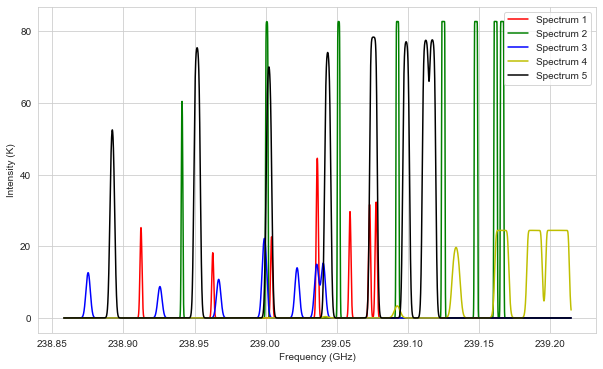

In [63]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

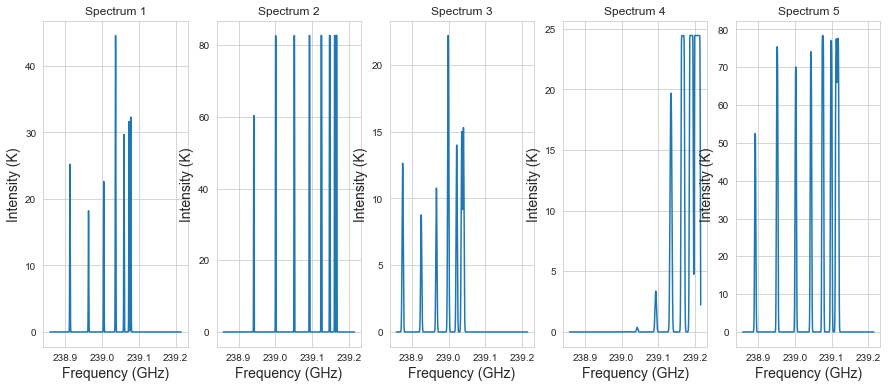

In [64]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [65]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [86]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 558))
approx_coeffs = np.zeros((len(signal), 558))
level = 6
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [87]:
feature_vector.shape

(10000, 35700)

In [88]:
start_timer = time.time()
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
print(time.time() - start_timer)
df_data

80.29916286468506


Frequency     Intensity
0          238.85800  1.826317e-14
1          238.85801  9.131584e-15
2          238.85802  9.131584e-15
3          238.85803  9.131584e-15
4          238.85804  9.131584e-15
...              ...           ...
356999995  239.21495  0.000000e+00
356999996  239.21496  0.000000e+00
356999997  239.21497  0.000000e+00
356999998  239.21498  0.000000e+00
356999999  239.21499  0.000000e+00

[357000000 rows x 2 columns]

In [89]:
detail_coeffs.shape
detail_coeffs

array([[ 4.38313245e-15, -5.11811677e-15,  3.64378105e-15, ...,
        -6.46841534e-15, -6.42465466e-15,  2.69825628e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.21100856e-17,  2.26050351e-16,  5.93537629e-16, ...,
        -7.24638497e-19, -2.20883517e-18,  2.84615224e-18],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.08237736e-17,  2.68550566e-16,  9.42423874e-16, ...,
        -1.36851147e-18, -7.18871804e-18, -1.63768445e-17],
       [-8.03167568e-01, -6.62414980e-01,  1.25340178e+00, ...,
        -1.20103040e+00,  1.94848641e-01,  2.12761635e+00]])

## Wavelet Decomposition Plots

In [90]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [91]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [92]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [93]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [94]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [95]:
# len(signal)

approx_coeffs.shape

(10000, 558)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [96]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

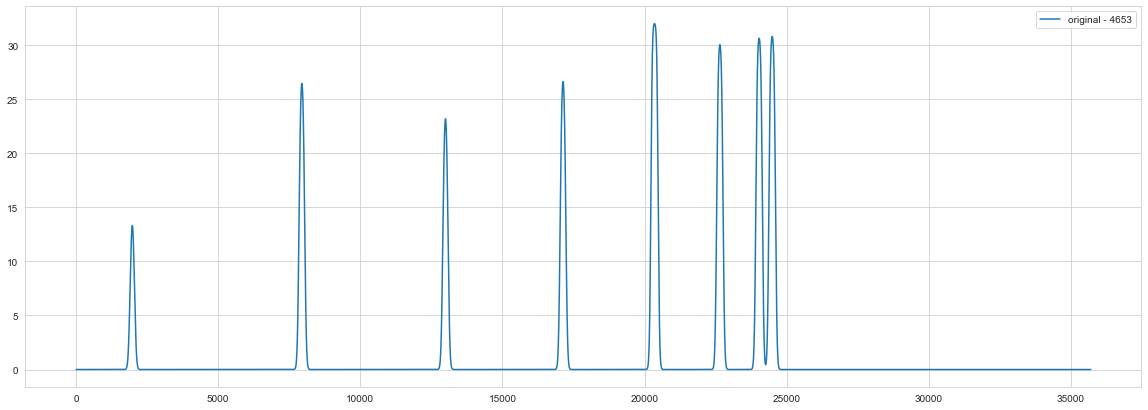

In [97]:
plt.figure(figsize=(20,7))
plt.plot(signal[4653], label='original - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/original.png")
plt.show()

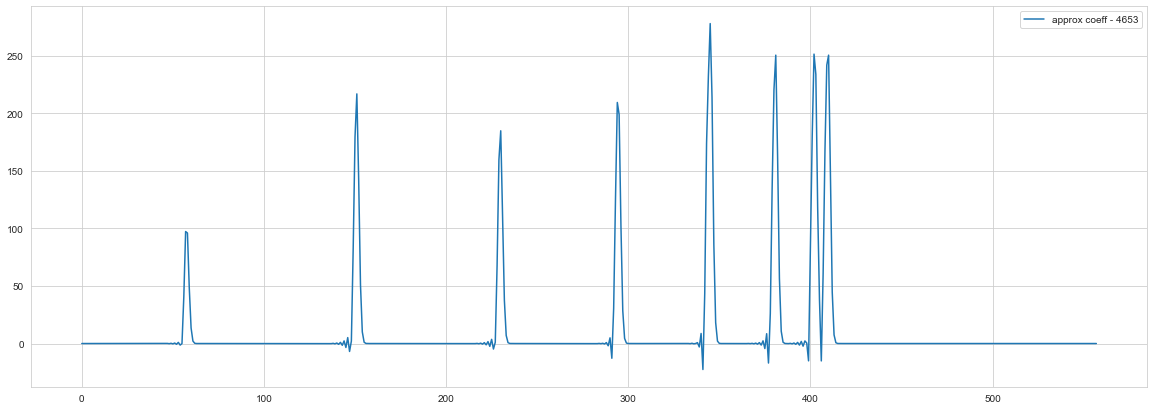

In [98]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[4653], label='approx coeff - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/approx.png")
plt.show()

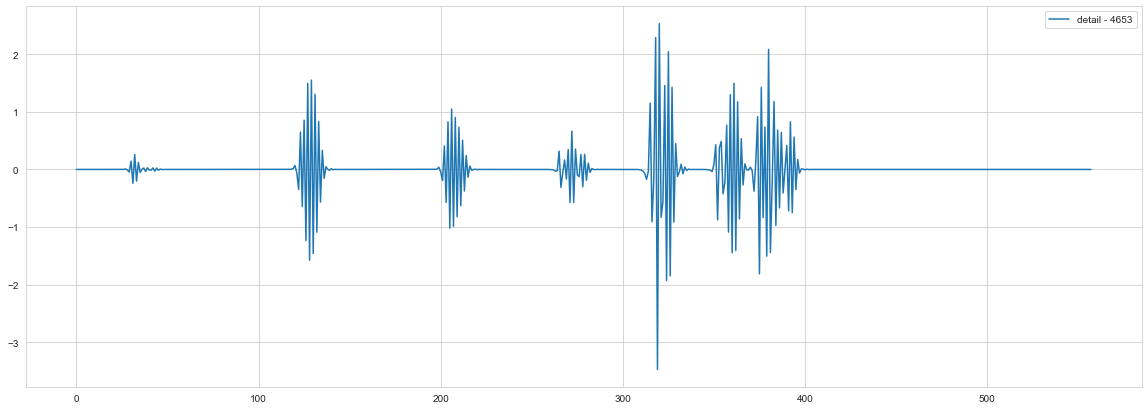

In [99]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[4653], label='detail - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/detail.png")
plt.show()

In [100]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)

feature_shape:  (10000, 558) labels_shape:  (10000, 5)


In [102]:
# labels_.drop(columns=['tcmb'], inplace=True)

#### save the true parameters to a file

In [85]:
labels_

A         fwhm          ntot      size         tex        vlsr
g                                                             
0     1.912290  1.096649e+16  2.065627  337.328826   75.372573
1     1.252128  7.060810e+16  2.120901   93.958451  -35.755035
2     4.283963  1.817762e+16  0.908718  384.198174  122.041115
3     5.741062  1.517674e+17  0.466794   27.458713  -87.431402
4     3.825326  1.945686e+17  1.761837  328.361198   25.830502
...        ...           ...       ...         ...         ...
9995  8.101635  3.112888e+17  2.327246   88.520308   80.467583
9996  5.979285  3.244454e+17  1.898521  372.110197   57.145780
9997  1.435561  1.368725e+16  1.984480  104.134197    2.442879
9998  7.169521  9.510809e+16  1.291843   91.973959   36.671214
9999  6.290287  2.409252e+16  0.765784  367.697843   71.563433

[10000 rows x 5 columns]

In [103]:
# get the last 3000 data of the parameters from labels 
df_param = df_param.iloc[-3000:, :]
# save the vals to a csv file
df_param.to_csv("data/10K_gen_files/true_param_vals.csv")
df_param.head()

A         fwhm          ntot      size         tex        vlsr
g                                                             
7000  6.313615  9.923154e+17  1.648660   93.904612  -87.462874
7001  9.828876  1.671634e+16  0.382131  145.852379   41.778945
7002  7.308771  5.944214e+17  0.297097   12.456551 -106.344352
7003  1.236440  2.357784e+16  0.916335   22.052204   30.409387
7004  4.343867  5.104086e+17  2.193175  215.423803  -79.721162

In [104]:
df = pd.DataFrame(approx_coeffs)

In [105]:
df

0             1             2             3             4    \
0     3.671317e-23 -2.452157e-23 -2.926957e-22  1.773886e-21 -5.876058e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     1.496090e-28  2.843491e-27 -1.571475e-26  1.839242e-26  1.446141e-25   
3     1.809781e+02  1.935439e+02  1.954276e+02  1.955688e+02  1.955746e+02   
4     0.000000e+00  0.000000e+00 -1.537245e-95 -2.098574e-83 -2.707633e-75   
...            ...           ...           ...           ...           ...   
9995  3.525189e-10  2.004572e-10 -5.130825e-09  3.781229e-08 -2.028958e-07   
9996  4.308310e-12  2.217579e-15 -2.951430e-11  4.247210e-10 -3.508520e-09   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -5.316010e-28  5.334674e-27 -1.010854e-26 -5.767894e-26  3.845246e-25   
9999  3.789438e-09  2.010561e-09 -5.332893e-08  4.198423e-07 -2.400239e-06   

               5             6             7             8             9    \
0     9.250883e-21  2.553009e-20 -2.595585e-19  1.146511e-18 -3.566853e-18   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -7.674518e-25  1.427348e-24  1.166280e-24 -1.544174e-23  6.880067e-23   
3     1.955754e+02  1.955760e+02  1.955776e+02  1.955754e+02  1.955838e+02   
4     1.914652e-69 -2.542766e-65  5.442306e-61 -1.444960e-57 -6.899570e-55   
...            ...           ...           ...           ...           ...   
9995  7.722088e-07 -1.878910e-06  1.272440e-06  1.300887e-05 -7.791789e-05   
9996  1.833129e-08 -6.594768e-08  1.622522e-07 -2.106408e-07 -3.068117e-07   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -7.490558e-25 -1.236138e-24  1.063014e-23 -2.875236e-23  6.546052e-23   
9999  9.712226e-06 -2.608048e-05  3.106438e-05  1.050587e-04 -8.098005e-04   

      ...           548           549           550           551  \
0     ... -2.195360e-29  1.016610e-28  3.798751e-28 -5.040659e-27   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.318389e-38 -2.657727e-36  2.415706e-35  3.705066e-35   
3     ...  1.960115e+02  1.946437e+02  1.974262e+02  1.942460e+02   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ... -3.916891e-16  3.083885e-16  1.335338e-14 -6.814473e-14   
9996  ... -6.713316e-18 -5.540155e-18  2.708089e-16 -1.004211e-15   
9997  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998  ... -1.670629e-37  2.040270e-36 -1.711065e-36 -3.749044e-34   
9999  ... -4.454226e-15  2.120389e-15  1.572916e-13 -7.536329e-13   

               552           553           554           555           556  \
0     1.396290e-26  3.795748e-26 -3.816207e-25  9.986146e-25  5.529243e-25   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -2.428334e-35  1.640309e-32 -3.511124e-31  1.044668e-30  1.640788e-29   
3     1.579903e+02  9.787952e+01  5.164519e+01  3.675989e+01  7.332392e+01   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995 -2.370859e-14  1.407991e-12 -5.217478e-12  1.302188e-12  5.363753e-11   
9996 -2.121889e-15  2.788799e-14 -7.634796e-14 -7.815060e-14  1.133144e-12   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998  5.610761e-33  1.960794e-32 -5.540775e-31  3.375511e-31  2.774101e-29   
9999 -4.953442e-13  1.651276e-11 -5.761649e-11  1.429253e-12  6.390064e-10   

               557  
0    -1.180830e-23  
1     0.000000e+00  
2    -1.375753e-28  
3     1.390479e+02  
4     0.000000e+00  
...            ...  
9995 -2.103763e-10  
9996 -3.393736e-12  
9997  0.000000e+00  
9998 -1.115325e-28  
9999 -2.368573e-09  

[10000 rows x 558 columns]

In [106]:
# convert the ntot column to log values 
labels_['ntot'] = np.log(labels_['ntot'])

In [107]:
labels_

A         fwhm       ntot      size         tex        vlsr
g                                                          
0     1.912290  36.933621  2.065627  337.328826   75.372573
1     1.252128  38.795921  2.120901   93.958451  -35.755035
2     4.283963  37.438968  0.908718  384.198174  122.041115
3     5.741062  39.561126  0.466794   27.458713  -87.431402
4     3.825326  39.809561  1.761837  328.361198   25.830502
...        ...        ...       ...         ...         ...
9995  8.101635  40.279497  2.327246   88.520308   80.467583
9996  5.979285  40.320894  1.898521  372.110197   57.145780
9997  1.435561  37.155241  1.984480  104.134197    2.442879
9998  7.169521  39.093790  1.291843   91.973959   36.671214
9999  6.290287  37.720678  0.765784  367.697843   71.563433

[10000 rows x 5 columns]

In [108]:
df = pd.concat([df, labels_], axis=1)

In [109]:
df

0             1             2             3             4  \
0     3.671317e-23 -2.452157e-23 -2.926957e-22  1.773886e-21 -5.876058e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     1.496090e-28  2.843491e-27 -1.571475e-26  1.839242e-26  1.446141e-25   
3     1.809781e+02  1.935439e+02  1.954276e+02  1.955688e+02  1.955746e+02   
4     0.000000e+00  0.000000e+00 -1.537245e-95 -2.098574e-83 -2.707633e-75   
...            ...           ...           ...           ...           ...   
9995  3.525189e-10  2.004572e-10 -5.130825e-09  3.781229e-08 -2.028958e-07   
9996  4.308310e-12  2.217579e-15 -2.951430e-11  4.247210e-10 -3.508520e-09   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -5.316010e-28  5.334674e-27 -1.010854e-26 -5.767894e-26  3.845246e-25   
9999  3.789438e-09  2.010561e-09 -5.332893e-08  4.198423e-07 -2.400239e-06   

                 5             6             7             8             9  \
0     9.250883e-21  2.553009e-20 -2.595585e-19  1.146511e-18 -3.566853e-18   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -7.674518e-25  1.427348e-24  1.166280e-24 -1.544174e-23  6.880067e-23   
3     1.955754e+02  1.955760e+02  1.955776e+02  1.955754e+02  1.955838e+02   
4     1.914652e-69 -2.542766e-65  5.442306e-61 -1.444960e-57 -6.899570e-55   
...            ...           ...           ...           ...           ...   
9995  7.722088e-07 -1.878910e-06  1.272440e-06  1.300887e-05 -7.791789e-05   
9996  1.833129e-08 -6.594768e-08  1.622522e-07 -2.106408e-07 -3.068117e-07   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -7.490558e-25 -1.236138e-24  1.063014e-23 -2.875236e-23  6.546052e-23   
9999  9.712226e-06 -2.608048e-05  3.106438e-05  1.050587e-04 -8.098005e-04   

      ...           553           554           555           556  \
0     ...  3.795748e-26 -3.816207e-25  9.986146e-25  5.529243e-25   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.640309e-32 -3.511124e-31  1.044668e-30  1.640788e-29   
3     ...  9.787952e+01  5.164519e+01  3.675989e+01  7.332392e+01   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ...  1.407991e-12 -5.217478e-12  1.302188e-12  5.363753e-11   
9996  ...  2.788799e-14 -7.634796e-14 -7.815060e-14  1.133144e-12   
9997  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998  ...  1.960794e-32 -5.540775e-31  3.375511e-31  2.774101e-29   
9999  ...  1.651276e-11 -5.761649e-11  1.429253e-12  6.390064e-10   

               557      fwhm       ntot      size         tex        vlsr  
0    -1.180830e-23  1.912290  36.933621  2.065627  337.328826   75.372573  
1     0.000000e+00  1.252128  38.795921  2.120901   93.958451  -35.755035  
2    -1.375753e-28  4.283963  37.438968  0.908718  384.198174  122.041115  
3     1.390479e+02  5.741062  39.561126  0.466794   27.458713  -87.431402  
4     0.000000e+00  3.825326  39.809561  1.761837  328.361198   25.830502  
...            ...       ...        ...       ...         ...         ...  
9995 -2.103763e-10  8.101635  40.279497  2.327246   88.520308   80.467583  
9996 -3.393736e-12  5.979285  40.320894  1.898521  372.110197   57.145780  
9997  0.000000e+00  1.435561  37.155241  1.984480  104.134197    2.442879  
9998 -1.115325e-28  7.169521  39.093790  1.291843   91.973959   36.671214  
9999 -2.368573e-09  6.290287  37.720678  0.765784  367.697843   71.563433  

[10000 rows x 563 columns]

In [110]:
X = df.iloc[:, :558]
y = df.iloc[:, -5:]

In [111]:
X

0             1             2             3             4    \
0     3.671317e-23 -2.452157e-23 -2.926957e-22  1.773886e-21 -5.876058e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     1.496090e-28  2.843491e-27 -1.571475e-26  1.839242e-26  1.446141e-25   
3     1.809781e+02  1.935439e+02  1.954276e+02  1.955688e+02  1.955746e+02   
4     0.000000e+00  0.000000e+00 -1.537245e-95 -2.098574e-83 -2.707633e-75   
...            ...           ...           ...           ...           ...   
9995  3.525189e-10  2.004572e-10 -5.130825e-09  3.781229e-08 -2.028958e-07   
9996  4.308310e-12  2.217579e-15 -2.951430e-11  4.247210e-10 -3.508520e-09   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -5.316010e-28  5.334674e-27 -1.010854e-26 -5.767894e-26  3.845246e-25   
9999  3.789438e-09  2.010561e-09 -5.332893e-08  4.198423e-07 -2.400239e-06   

               5             6             7             8             9    \
0     9.250883e-21  2.553009e-20 -2.595585e-19  1.146511e-18 -3.566853e-18   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -7.674518e-25  1.427348e-24  1.166280e-24 -1.544174e-23  6.880067e-23   
3     1.955754e+02  1.955760e+02  1.955776e+02  1.955754e+02  1.955838e+02   
4     1.914652e-69 -2.542766e-65  5.442306e-61 -1.444960e-57 -6.899570e-55   
...            ...           ...           ...           ...           ...   
9995  7.722088e-07 -1.878910e-06  1.272440e-06  1.300887e-05 -7.791789e-05   
9996  1.833129e-08 -6.594768e-08  1.622522e-07 -2.106408e-07 -3.068117e-07   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998 -7.490558e-25 -1.236138e-24  1.063014e-23 -2.875236e-23  6.546052e-23   
9999  9.712226e-06 -2.608048e-05  3.106438e-05  1.050587e-04 -8.098005e-04   

      ...           548           549           550           551  \
0     ... -2.195360e-29  1.016610e-28  3.798751e-28 -5.040659e-27   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.318389e-38 -2.657727e-36  2.415706e-35  3.705066e-35   
3     ...  1.960115e+02  1.946437e+02  1.974262e+02  1.942460e+02   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ... -3.916891e-16  3.083885e-16  1.335338e-14 -6.814473e-14   
9996  ... -6.713316e-18 -5.540155e-18  2.708089e-16 -1.004211e-15   
9997  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998  ... -1.670629e-37  2.040270e-36 -1.711065e-36 -3.749044e-34   
9999  ... -4.454226e-15  2.120389e-15  1.572916e-13 -7.536329e-13   

               552           553           554           555           556  \
0     1.396290e-26  3.795748e-26 -3.816207e-25  9.986146e-25  5.529243e-25   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -2.428334e-35  1.640309e-32 -3.511124e-31  1.044668e-30  1.640788e-29   
3     1.579903e+02  9.787952e+01  5.164519e+01  3.675989e+01  7.332392e+01   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995 -2.370859e-14  1.407991e-12 -5.217478e-12  1.302188e-12  5.363753e-11   
9996 -2.121889e-15  2.788799e-14 -7.634796e-14 -7.815060e-14  1.133144e-12   
9997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9998  5.610761e-33  1.960794e-32 -5.540775e-31  3.375511e-31  2.774101e-29   
9999 -4.953442e-13  1.651276e-11 -5.761649e-11  1.429253e-12  6.390064e-10   

               557  
0    -1.180830e-23  
1     0.000000e+00  
2    -1.375753e-28  
3     1.390479e+02  
4     0.000000e+00  
...            ...  
9995 -2.103763e-10  
9996 -3.393736e-12  
9997  0.000000e+00  
9998 -1.115325e-28  
9999 -2.368573e-09  

[10000 rows x 558 columns]

In [112]:
y

fwhm       ntot      size         tex        vlsr
0     1.912290  36.933621  2.065627  337.328826   75.372573
1     1.252128  38.795921  2.120901   93.958451  -35.755035
2     4.283963  37.438968  0.908718  384.198174  122.041115
3     5.741062  39.561126  0.466794   27.458713  -87.431402
4     3.825326  39.809561  1.761837  328.361198   25.830502
...        ...        ...       ...         ...         ...
9995  8.101635  40.279497  2.327246   88.520308   80.467583
9996  5.979285  40.320894  1.898521  372.110197   57.145780
9997  1.435561  37.155241  1.984480  104.134197    2.442879
9998  7.169521  39.093790  1.291843   91.973959   36.671214
9999  6.290287  37.720678  0.765784  367.697843   71.563433

[10000 rows x 5 columns]

In [35]:
# from sklearn.preprocessing import LabelEncoder

# lbl_enc = LabelEncoder()

# labl = lbl_enc.fit_transform(labels_)

In [113]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (7000, 558) 
 y_train shape:  (7000, 5) 
 X_test shape:  (3000, 558) 
 y_test shape:  (3000, 5)


## 1. Multioutput Regressor - Random Forest

In [119]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler


regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
    n_estimators=800, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=130,
    bootstrap=True
    )
)


# pipe = make_pipeline(StandardScaler(), regr_multirf)
# pipe.fit(X_train, y_train)  # apply scaling on training data


# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

# multioutput regressor
regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=130,
                                                     n_estimators=800))

In [120]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

In [123]:
regr_multirf.score(X_test, y_test)

0.7550076280772939

In [124]:
# print('true val: {}'.format(y_test.iloc[:, 0]), 'pred_value: {}'.format( y_multirf_pred[:,0]))

In [125]:
# print('true val: {}'.format(y_test.iloc[:, 1]), 'pred_value: {}'.format( y_multirf_pred[:,1]))

In [126]:
# print('true val: {}'.format(y_test.iloc[:, 2]), 'pred_value: {}'.format( y_multirf_pred[:,2]))

In [127]:
# print('true val: {}'.format(y_test.iloc[:, 3]), 'pred_value: {}'.format( y_multirf_pred[:,3]))

In [128]:
# print('true val: {}'.format(y_test.iloc[:, 4]), 'pred_value: {}'.format( y_multirf_pred[:,4]))

#### Metrics

In [129]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error( y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [130]:
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  13.433903269644734
Multirf  mse:  1223.191921098958
Multirf  rmse:  34.9741607633258
Multirf  mape:  fwhm     9.123699
ntot     1.721280
size    31.877234
tex     64.642825
vlsr     9.089549
dtype: float64
Multirf  r2:  0.7550076280772939
Multirf  msle:  34.9741607633258


### Predicted vs True values plots

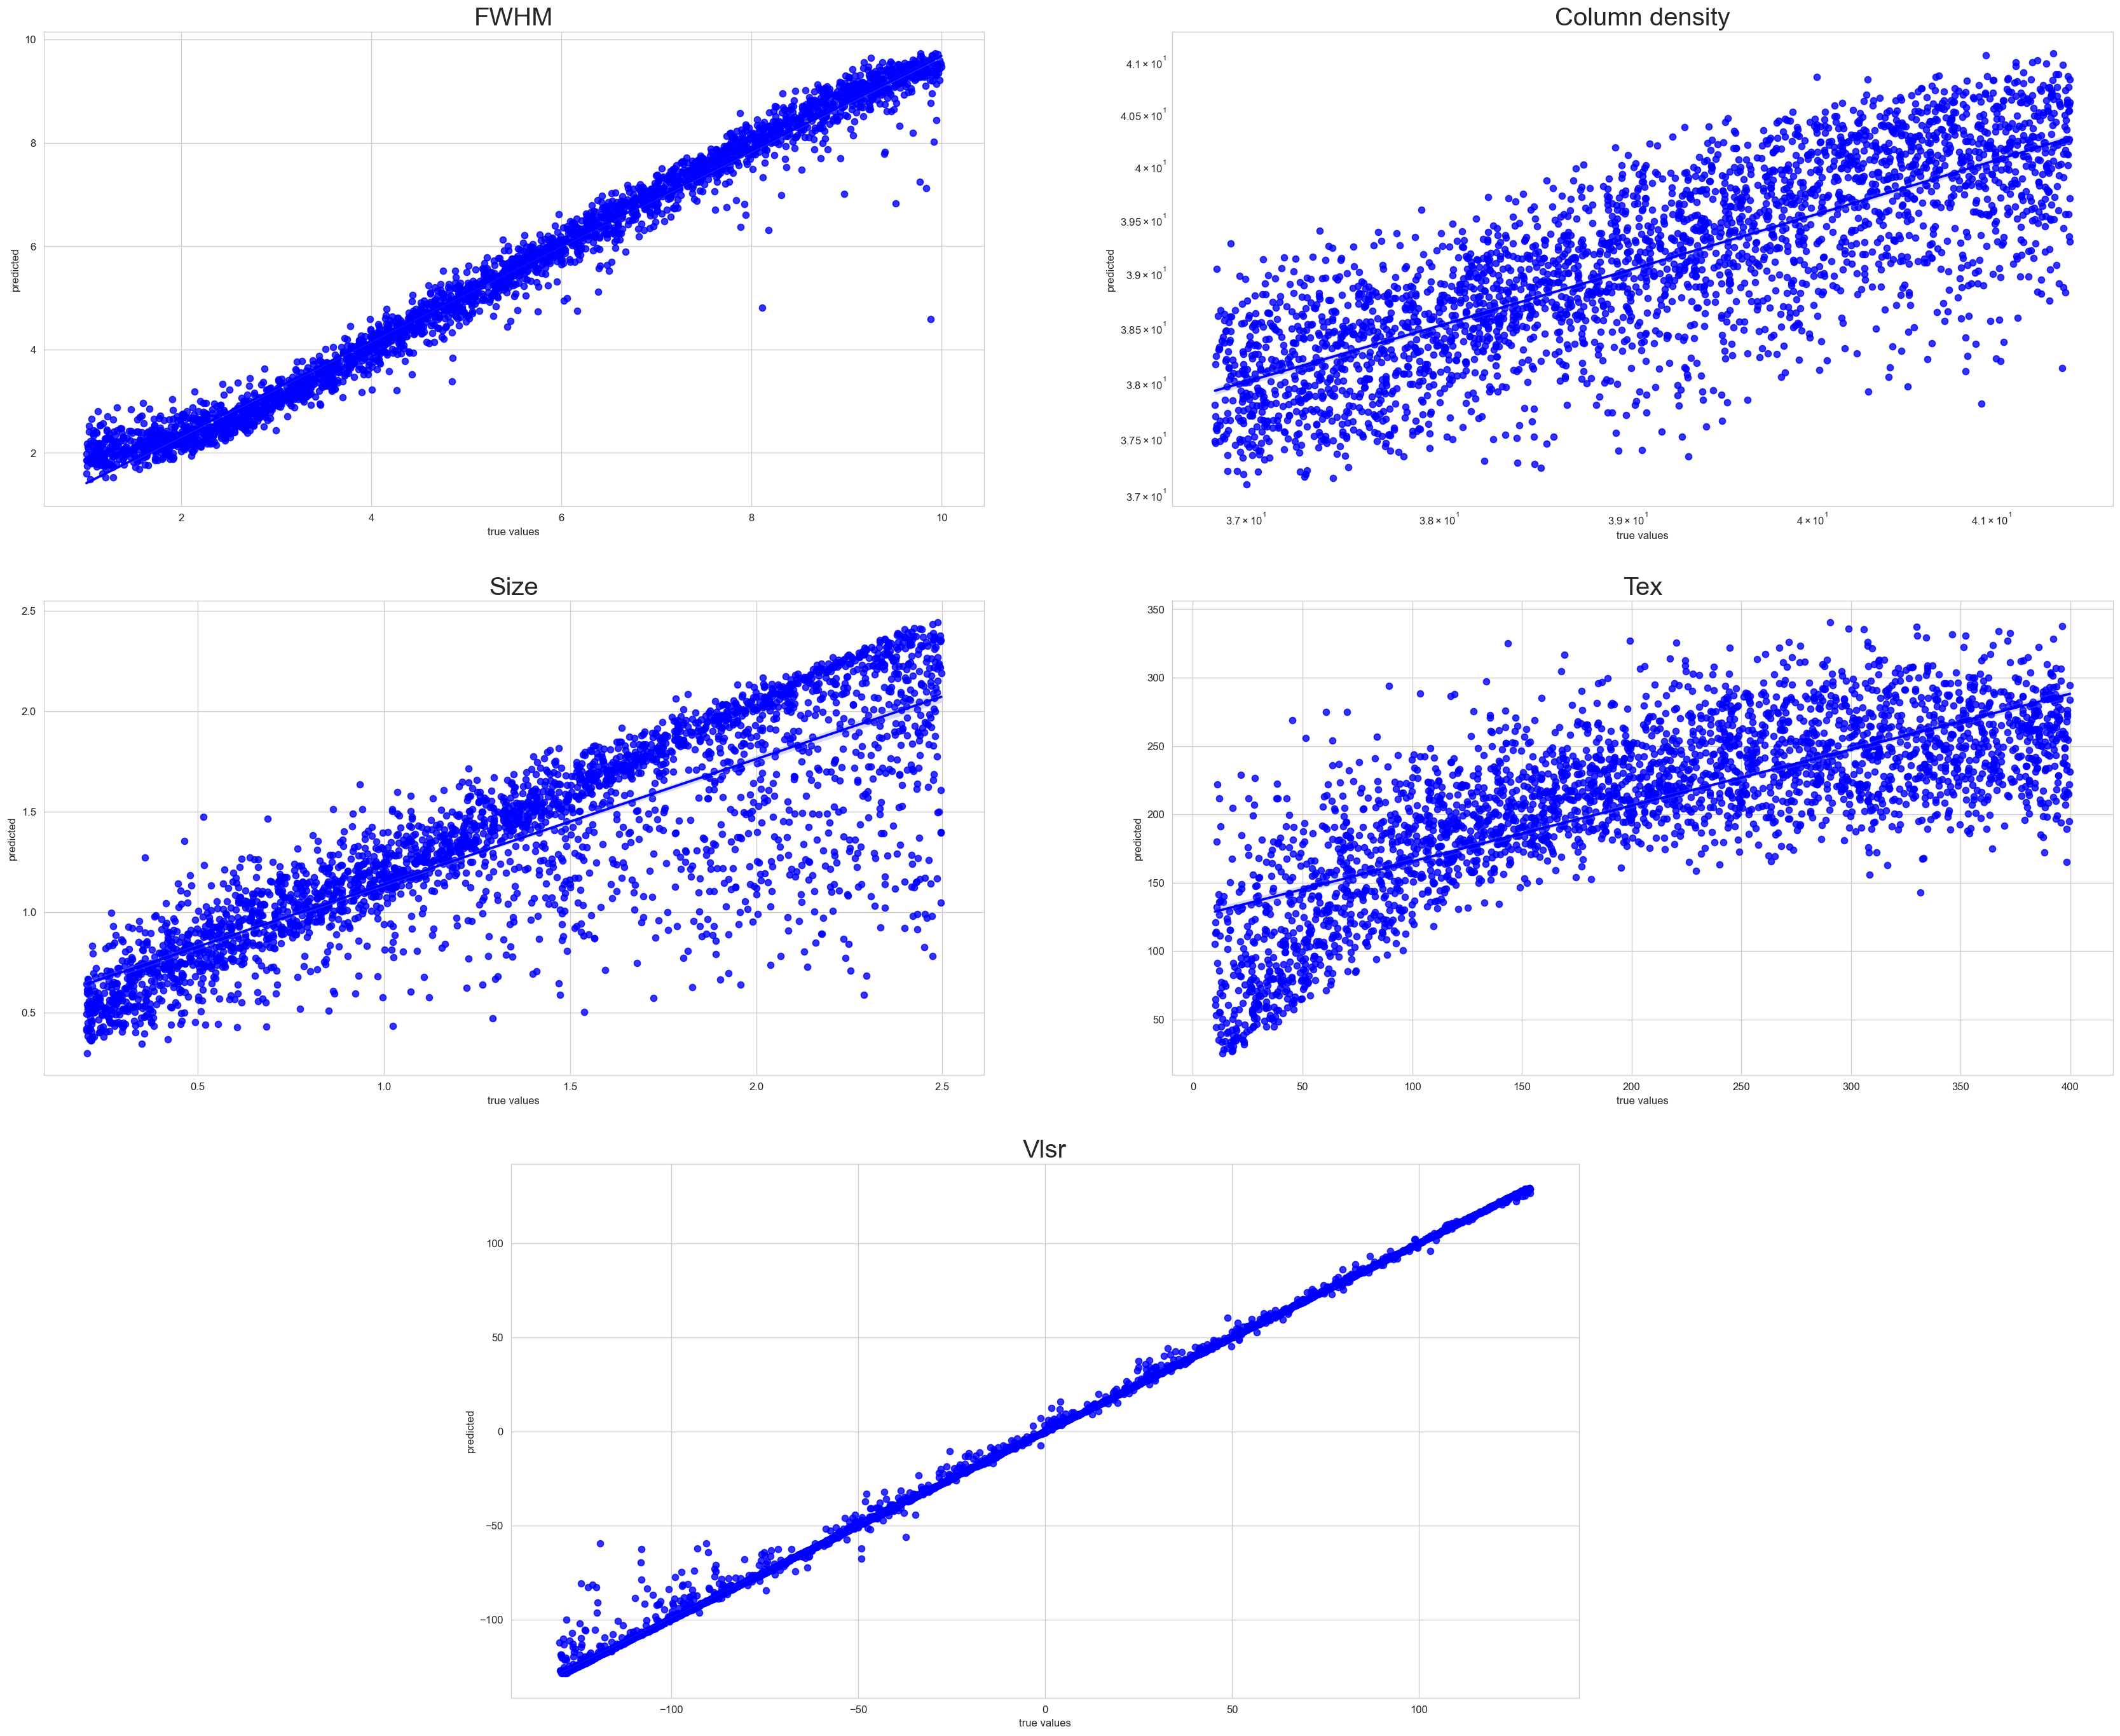

In [131]:
fig, axes = plt.subplots(3, 2, figsize=(35,28), dpi=120)
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2)
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr


g1.set(title='FWHM', ylabel="predicted", xlabel="true values")
g2.set(title='Column density', ylabel="predicted", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted", xlabel="true values")
g4.set(title='Tex', ylabel="predicted", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_RF.png")

plt.show()

### 3D Plots -cColumnn density, Excitation temperature and Size

In [132]:
pred_param = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param.head()

fwhm       ntot      size         tex        vlsr
0  8.106479  40.235546  1.984865  279.973688  -83.783914
1  6.507296  37.564364  0.884083  311.279472   71.589188
2  2.411873  39.678647  1.930967  234.697310 -105.926359
3  3.020264  40.227618  1.953033  252.115324 -109.365712
4  3.654106  39.340981  1.070903  108.816280   41.698298

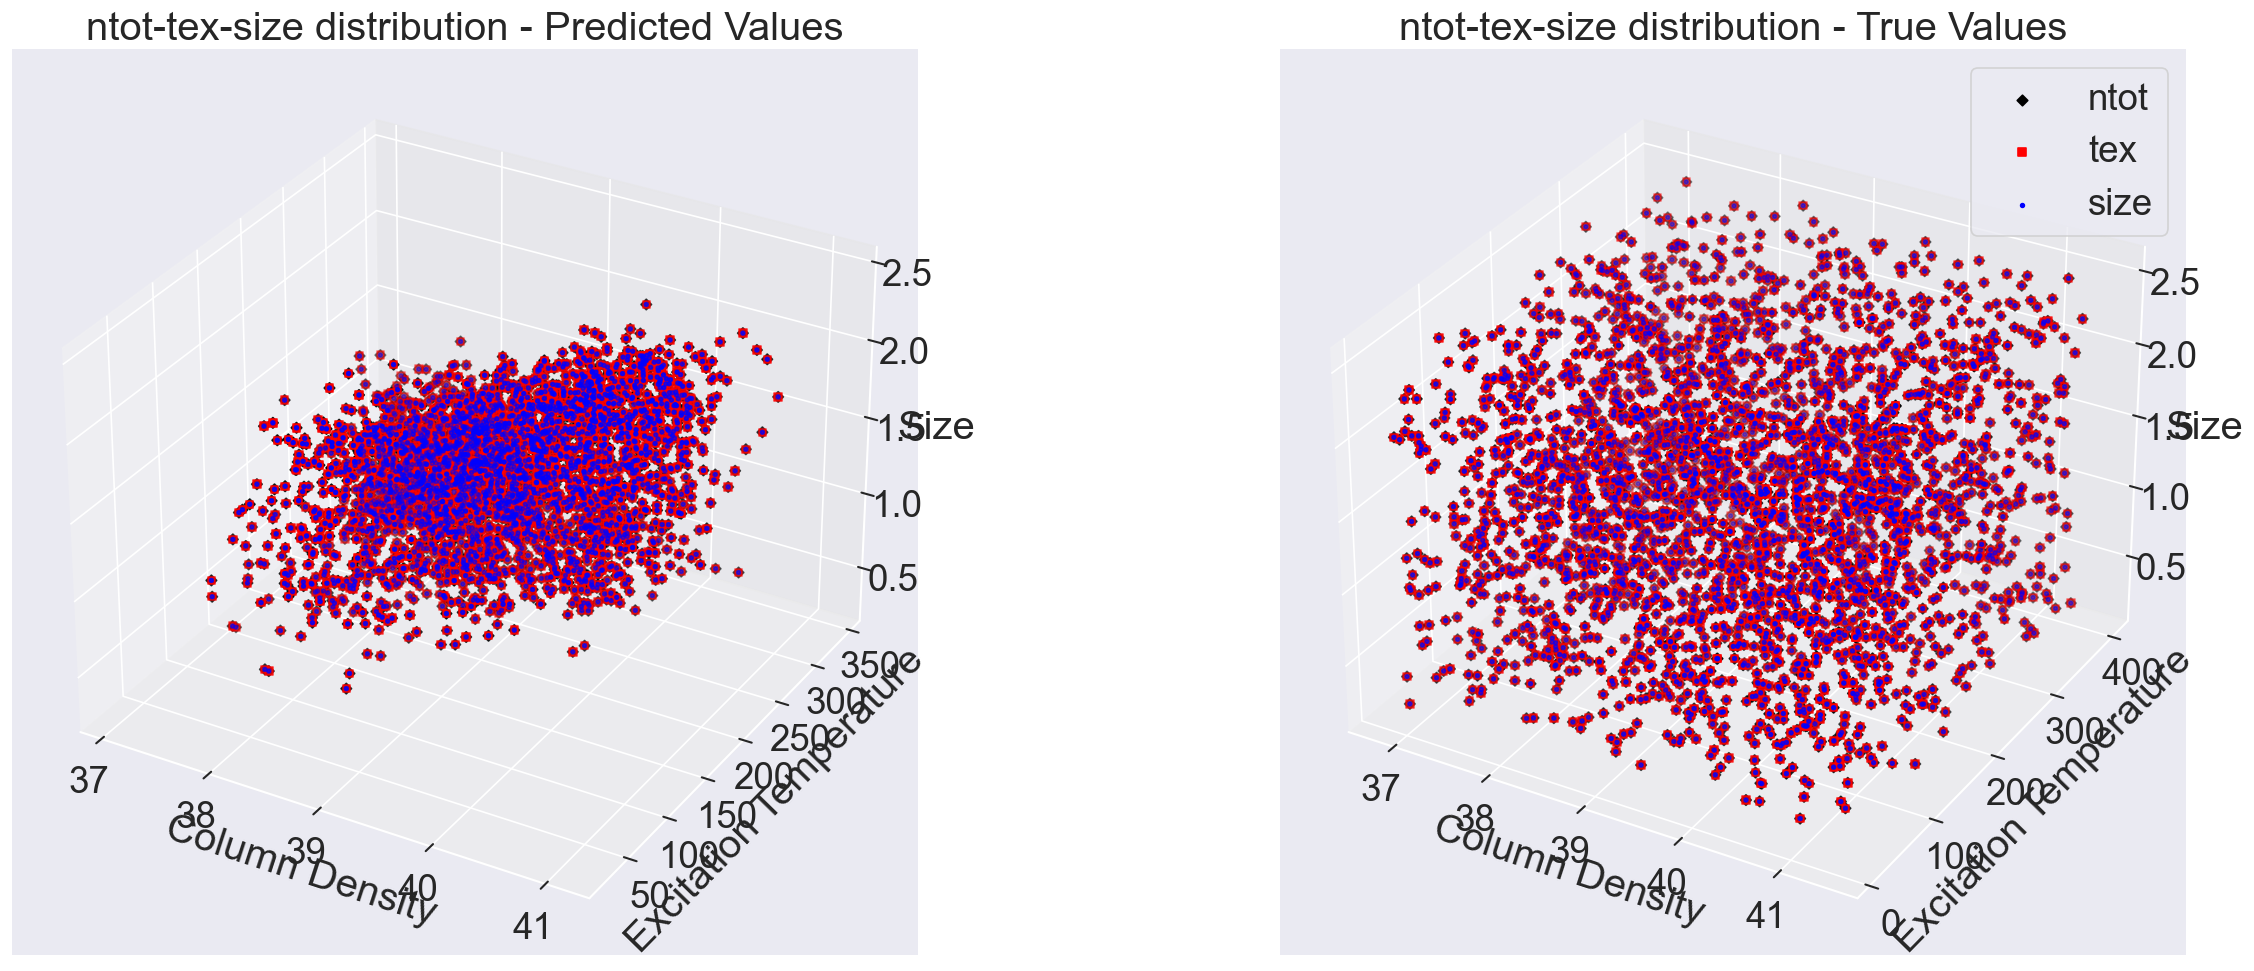

In [133]:
fig = plt.figure(figsize=(25, 10), dpi=120)
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param['ntot']
    y1 = pred_param['tex']
    z1 = pred_param['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

## Hyperparameter Tuning for Random Forest

In [141]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10)
)


In [142]:
random_search = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=30,
    cv=5,
    verbose=5,
    pre_dispatch="2*n_jobs",
    n_jobs=-1,
    error_score="raise",
    random_state=42,
    return_train_score=True
)

In [143]:
hyper_rf_tuned_model = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 2/5] END estimator__max_depth=30, estimator__n_estimators=200;, score=(train=0.915, test=0.723) total time=94.1min
[CV 1/5] END estimator__max_depth=30, estimator__n_estimators=200;, score=(train=0.914, test=0.717) total time=94.5min
[CV 3/5] END estimator__max_depth=30, estimator__n_estimators=200;, score=(train=0.913, test=0.721) total time=94.6min
[CV 2/5] END estimator__max_depth=90, estimator__n_estimators=200;, score=(train=0.964, test=0.738) total time=103.4min
[CV 1/5] END estimator__max_depth=90, estimator__n_estimators=200;, score=(train=0.964, test=0.732) total time=103.8min
[CV 4/5] END estimator__max_depth=90, estimator__n_estimators=200;, score=(train=0.964, test=0.741) total time=103.9min
[CV 5/5] END estimator__max_depth=90, estimator__n_estimators=200;, score=(train=0.964, test=0.748) total time=104.1min
[CV 3/5] END estimator__max_depth=90, estimator__n_estimators=200;, score=(train=0.964, test=0.735) t

In [ ]:
print("Best hyperparameters: ", hyper_rf_tuned_model.best_params_)
print("Best score: ", hyper_rf_tuned_model.best_score_)

In [ ]:
tuned_model = hyper_rf_tuned_model.best_estimator_
tuned_model.predict(X_test)

In [51]:
# print(tuned_model)

In [52]:
# TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, tuned_model.predict(X_test)))

In [53]:
# print(y_test.iloc[:,0], y_tuned_pred[:,0])

## 2. XGBoost Regressor

In [54]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
))



# xgb_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__max_leaves=np.arange(10, 150, 10),
#     estimator__max_bin=np.arange(10, 150, 10),
#     # estimator_growth_policy=0,
#     estimator__learning_rate=np.arange(0.1, 1, 0.1),
#     estimator__min_child_weight=np.arange(1.0, 5.0, 0.5),
#     estimator__max_delta_step=np.arange(0, 10, 1),
#     estimator__importance_type=["gain", "weight", "cover", "total_gain", "total_cover"],
#     estimator__eval_metric=[metrics.mean_absolute_error, metrics.mean_squared_error]
# )

# xgbr_rand_search = RandomizedSearchCV(
#     estimator=multixgb_model,
#     param_distributions=xgb_hyperparameters,
#     n_iter=100,
#     cv=3
# )

# xgb_hyperparameters_tuning = xgbr_rand_search.fit(X_train, y_train)
# print('Best Parameters = {}'.format(xgb_hyperparameters_tuning.best_params_))

# xgb_tuned_model = xgb_hyperparameters_tuning.best_estimator_
multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7ff116557e50>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [55]:
# predict on the neew test et
y_multixgb_pred = multixgb_model.predict(X_test)

In [56]:
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

Multirf  mae:  2.430092063062449e+16
Multirf  mse:  6.361256385026373e+33
Multirf  rmse:  7.975748482134058e+16
Multirf  mape:  A
fwhm      4.454132
ntot    150.388482
size     38.835644
tex      61.043108
vlsr     11.935808
dtype: float64
Multirf  r2:  0.7200396879466514
Multirf  msle:  7.975748482134058e+16


### Predicted vs True values Plots - XGB Regressor

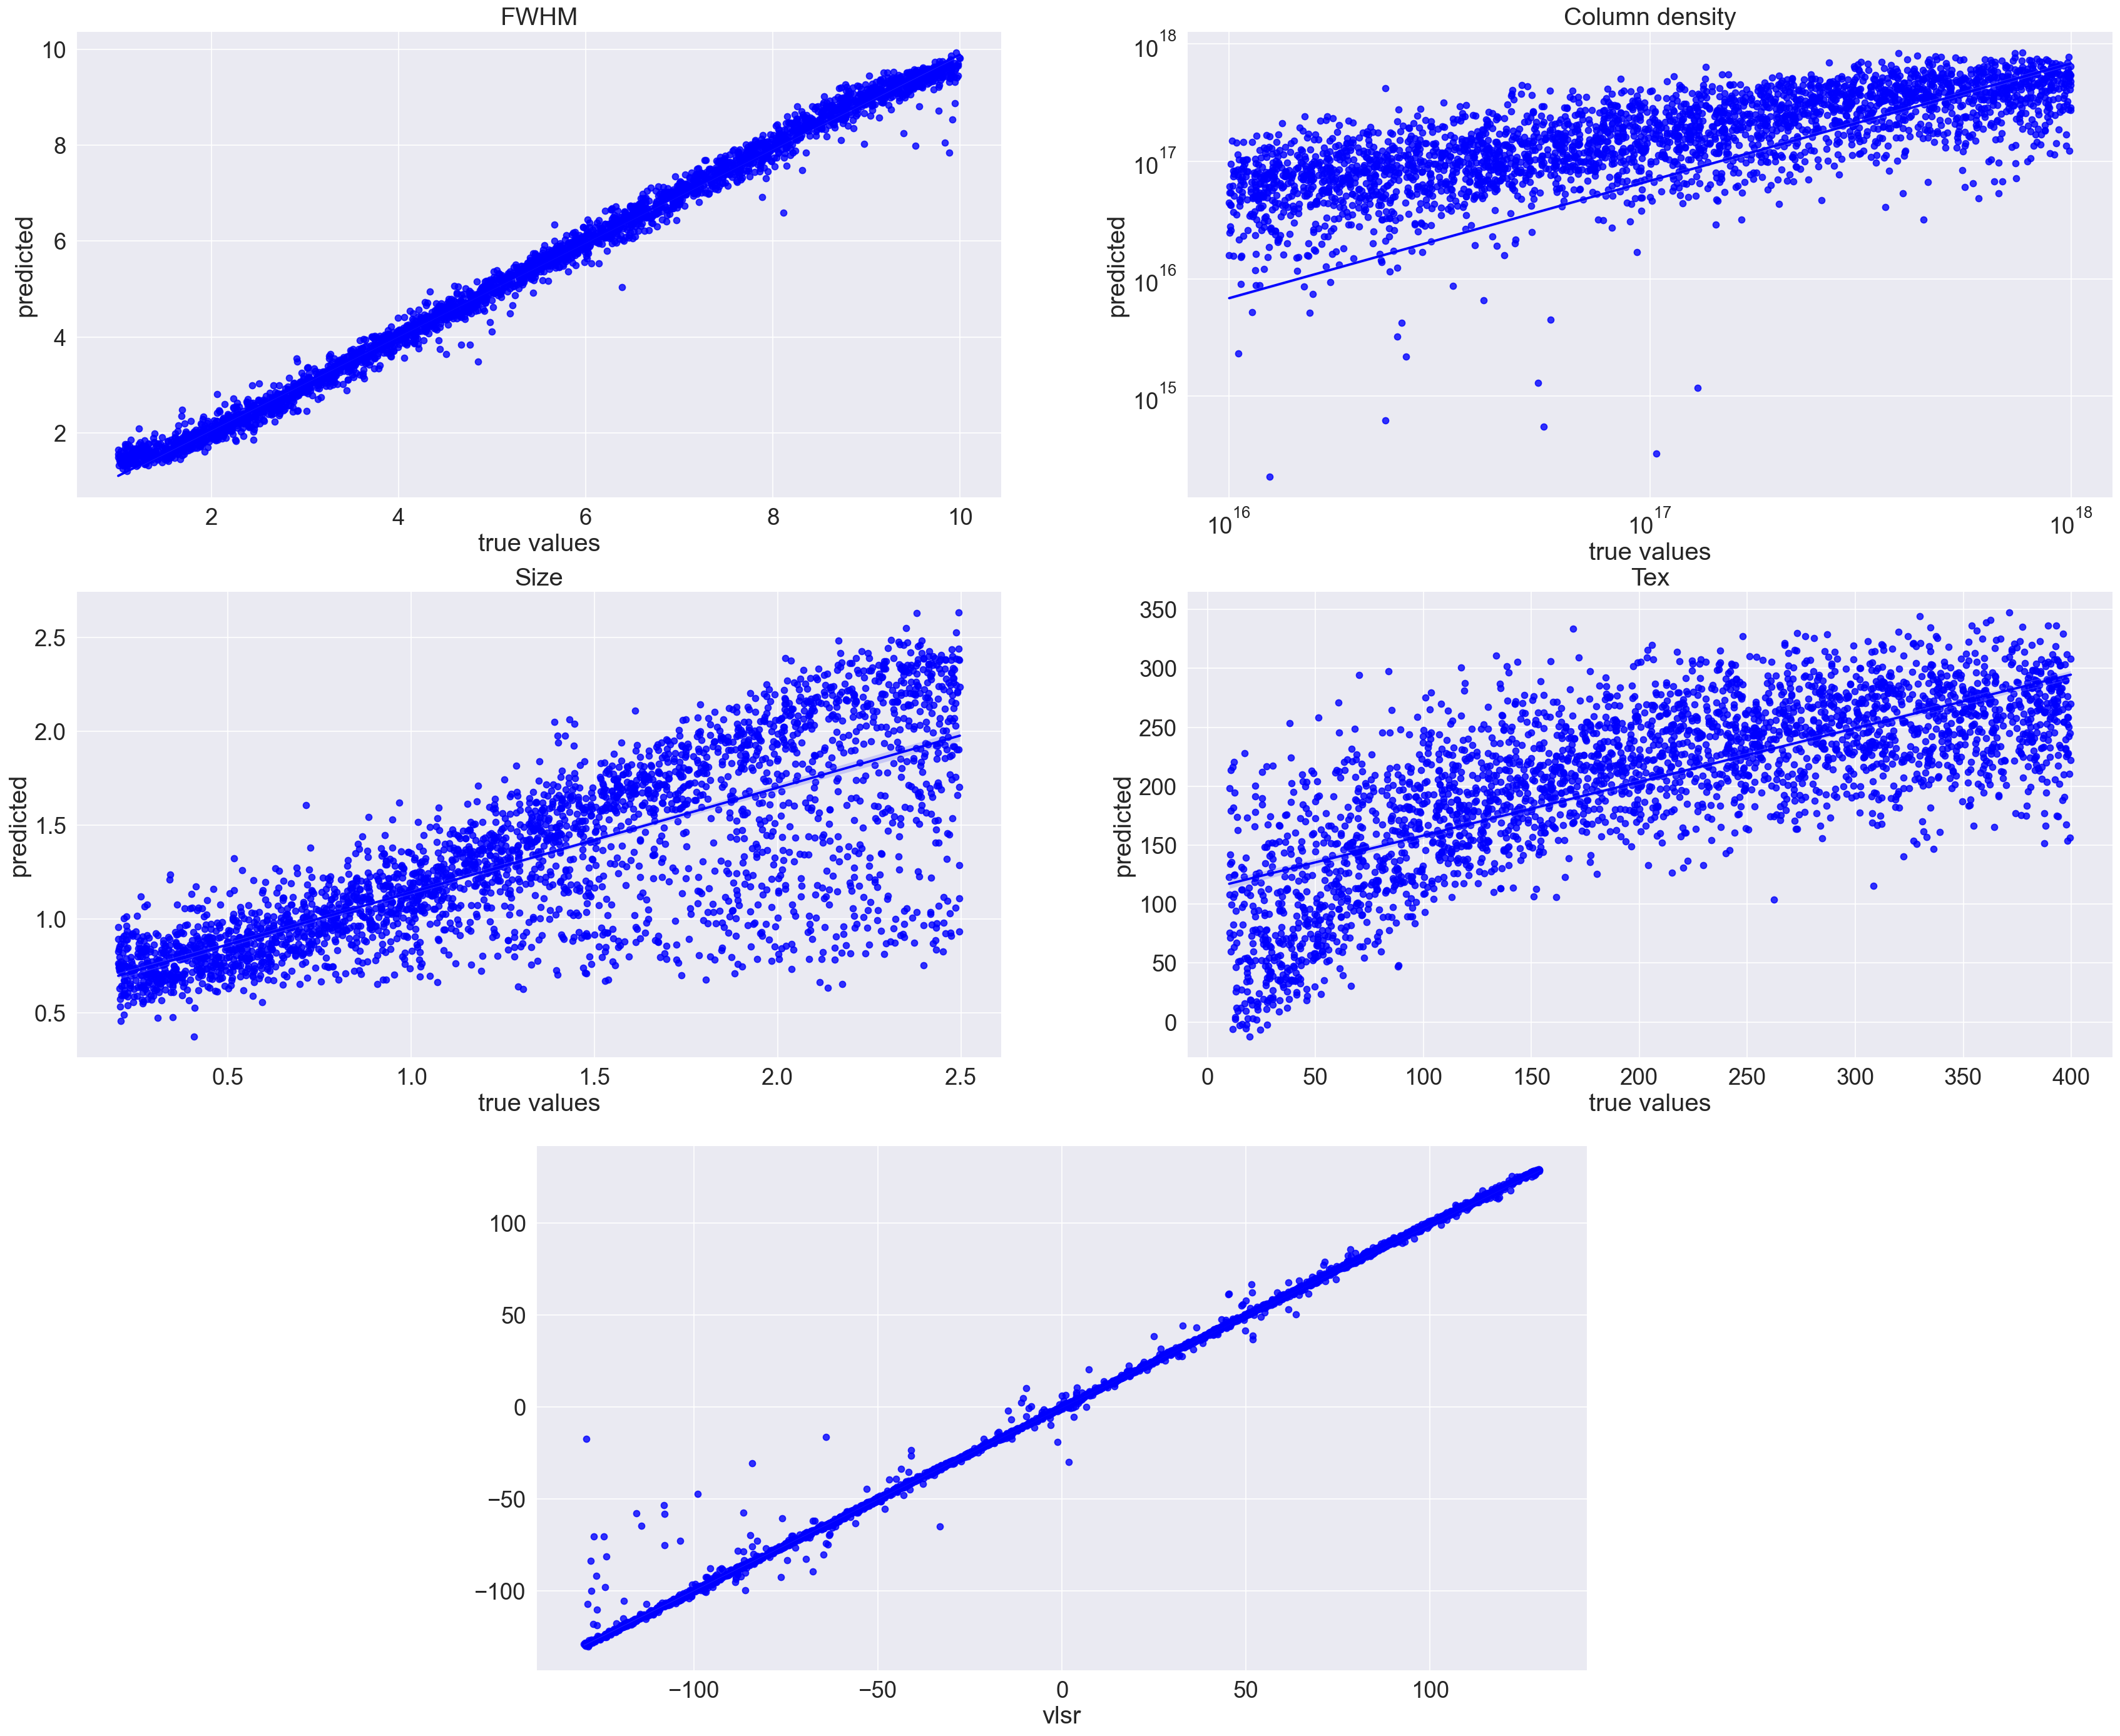

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(35,28), dpi=120)
sns.set_theme(style='whitegrid', font_scale=2)
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])


g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multixgb_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted", xlabel="true values")
g2.set(title='Column density', ylabel="predicted", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted", xlabel="true values")
g4.set(title='Tex', ylabel="predicted", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted", xlabel="true values")

plt.show()

### 3D scatter splots -  Columnn density, Excitation temperature and Size (XGB Regresoor)

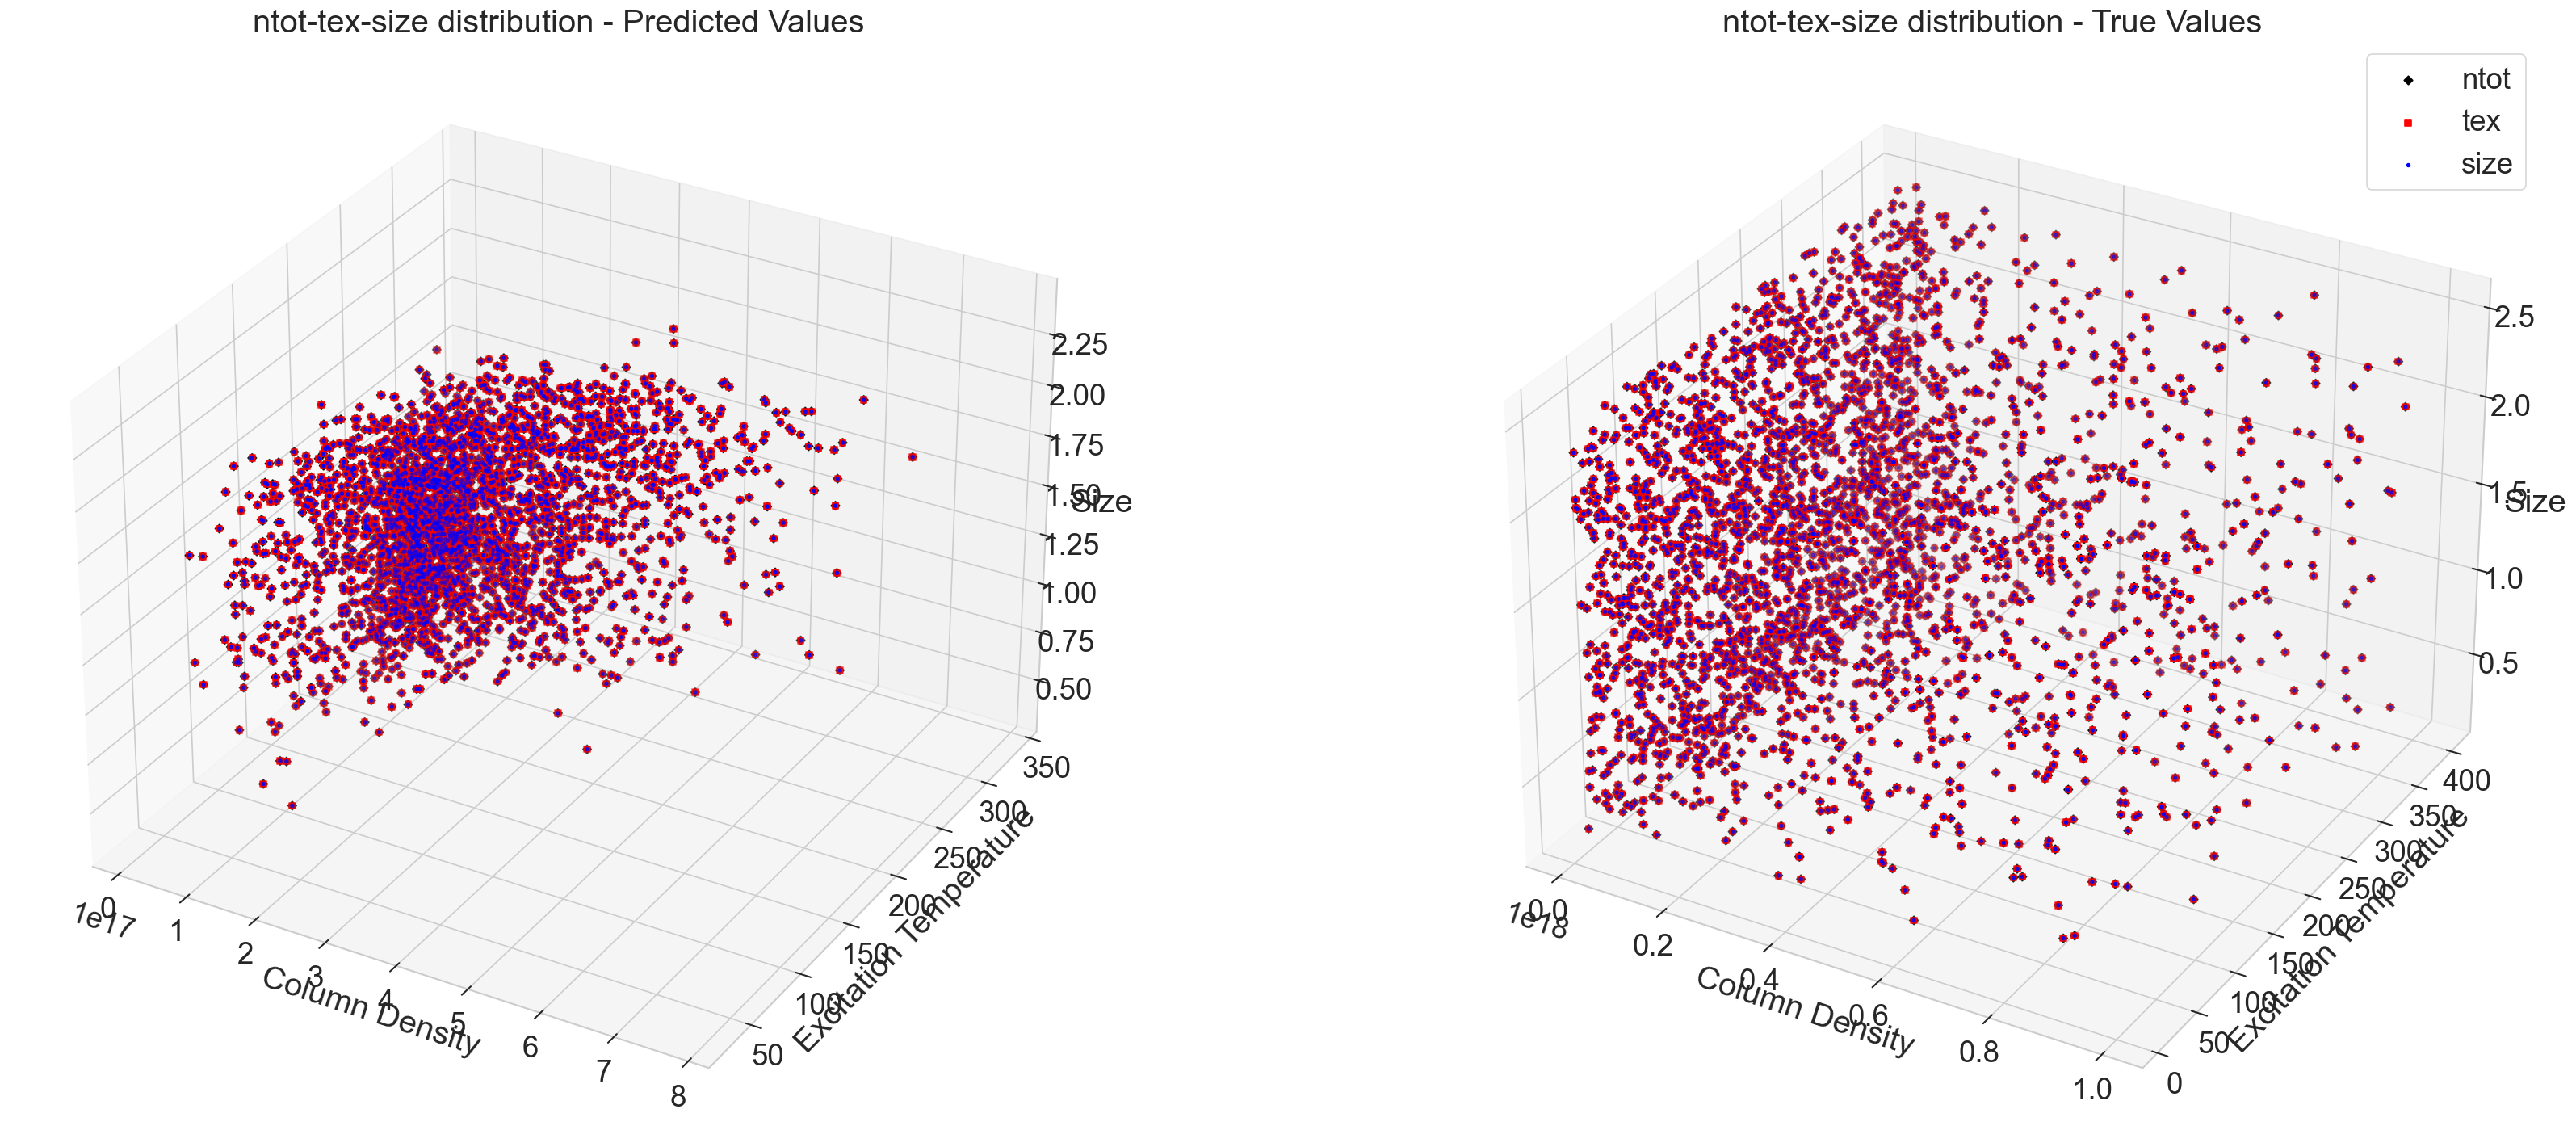

In [58]:
fig = plt.figure(figsize=(35, 15), dpi=120)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param['ntot']
    y1 = pred_param['tex']
    z1 = pred_param['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

### Gradient Boosting Regressor - Grid Search for Hyperparameters

In [59]:
# model = MultiOutputRegressor(
#     GradientBoostingRegressor(
#         loss='ls', 
#         learning_rate=0.1, 
#         n_estimators=100, 
#         subsample=1.0,
#         criterion='friedman_mse', 
#         min_samples_split=2,
#         min_samples_leaf=1,
#         min_weight_fraction_leaf=0.0,
#         max_depth=3,
#         min_impurity_decrease=0.0,
#         init=None, 
#         random_state=None,
#         max_features=None,
#         alpha=0.9, 
#         verbose=0, 
#         max_leaf_nodes=None, 
#         warm_start=False,
#         validation_fraction=0.1, 
#         n_iter_no_change=None, 
#         tol=0.0001,
#         ccp_alpha=0.0))

# hyperparameters = dict(
#     estimator__learning_rate=[0.0001, 0.05, 0.1, 0.2, 0.5, 0.9], 
#     estimator__loss=['ls', 'absolute_error', 'huber'],
#     estimator__n_estimators=[10, 20, 50, 100, 200, 300, 500, 700, 1000],
#     estimator__criterion=['friedman_mse', 'squared_error'], 
#     estimator__min_samples_split=np.arange(2, 12, 2),
#     estimator__max_depth=[3, 5, 10, 15, 20, 30], 
#     estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
#     estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
#     estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

# randomized_search = RandomizedSearchCV(
#     model, 
#     hyperparameters, 
#     random_state=0, 
#     n_iter=5, 
#     scoring=None,
#     n_jobs=2, 
#     refit=True, 
#     cv=5, 
#     verbose=True,
#     pre_dispatch='2*n_jobs', 
#     error_score='raise', 
#     return_train_score=True)

# hyperparameters_tuning = randomized_search.fit(X_train, y_train)
# print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

# tuned_model = hyperparameters_tuning.best_estimator_

In [60]:
# print(tuned_model.predict(X_test))

In [61]:
# # use the metrics class to calculate the metrics from the tuned model
# eval = RegressionMetrics()
# for metric in ["mae", "mse", "rmse", "mape", "r2", "msle"]:
#     print(metric, ":", eval.get_metric(metric, y_test, tuned_model.predict(X_test)))
# #
